## Mounting drive to the notebook
- to mount this notebook in your DRIVE, change the `root_path` to the path of the folder

In [1]:
root_path = 'Colab Notebooks/RNN-Captioning/'

In [2]:
!pip install torchinfo
%load_ext autoreload
%autoreload 2
import os
import sys
from google.colab import drive

drive.mount('/content/drive/',force_remount=True)
PROJECT_PATH  = os.path.join('/content/drive/MyDrive/',root_path)
os.chdir(PROJECT_PATH)
sys.path.append(PROJECT_PATH)

print('Working directory is: ',os.getcwd())
print('Files in the PROJECT_PATH: ')
!ls '{PROJECT_PATH}'

Mounted at /content/drive/
Working directory is:  /content/drive/MyDrive/Colab Notebooks/RNN-Captioning
Files in the PROJECT_PATH: 
coco  data  features  model  model_checkpoints	notebooks


In [19]:
import json
import torch
import random
import torch.nn as nn
from tqdm.notebook import trange,tqdm
from data import *
from model.LSTM import BahdanauLSTM
from model.backbone import CNNBackbone
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import numpy as np
import cv2 as cv

device = 'cuda' if torch.cuda.is_available() else 'cpu'
test_path = f'{PROJECT_PATH}/coco/test2.json'
test_images = f'{PROJECT_PATH}/coco/test-images'
vocab_path = f'{PROJECT_PATH}/coco/vocab03.json'
model_path = f'{PROJECT_PATH}/model'
model_checkpoint = f'{PROJECT_PATH}/model_checkpoints'

# Importing the necessary modules and initializing the model

In [6]:
resnet50 = CNNBackbone('r50',attention=True,device=device)
vgg19 = CNNBackbone('vgg19',attention=True,device=device)
with open(test_path) as f:
  enc_test = json.load(f)

vocab = Vocabulary()
vocab.load(vocab_path)
vocab.__len__()

vgg_model_01= torch.load(os.path.join(model_checkpoint,'vgg_model_01.pt'))
best_vgg_model= torch.load(os.path.join(model_checkpoint,'best_vgg_model.pt'))
resent_model= torch.load(os.path.join(model_checkpoint,'resnet_model.pt'))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s]
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:10<00:00, 53.9MB/s]


In [14]:
random.choice(enc_test[0]['captions'])

'a mini office waiting for a human being to work properly'

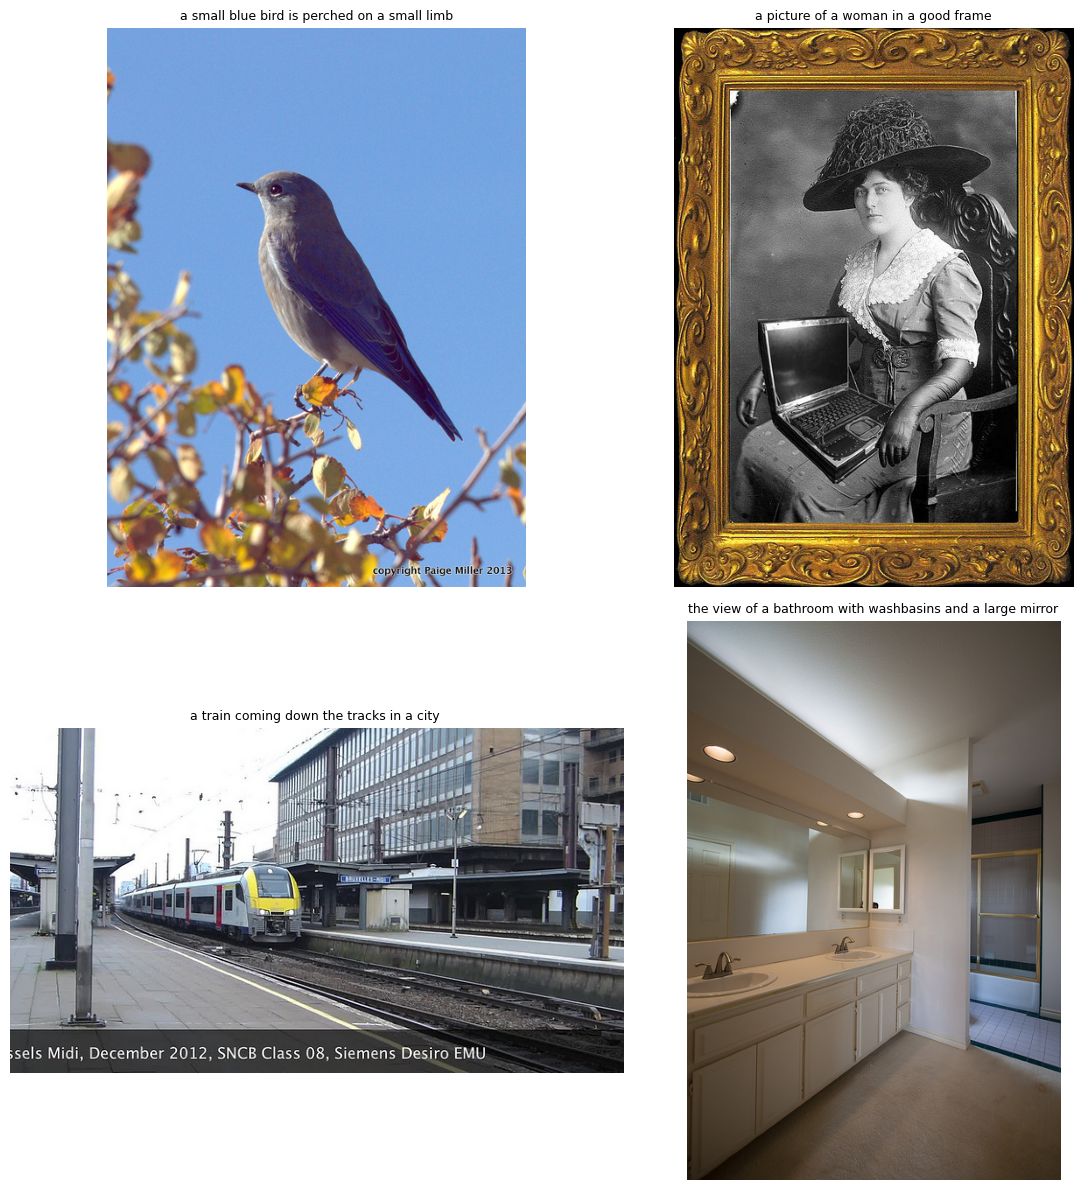

In [18]:
show_data(enc_test,test_images,vocab)

In [ ]:
model_01 = BahdanauLSTM(
    vocab,
    vgg_model_01['feature_map_dim'],
    vgg_model_01['embedding_dim'],
    vgg_model_01['hidden_dim'],
    vgg_model_01['dropout'],
    device=device
)
model_01.load_state_dict(vgg_model_01['state_dict'])
best_model = BahdanauLSTM(
    vocab,
    best_vgg_model['feature_map_dim'],
    best_vgg_model['embedding_dim'],
    best_vgg_model['hidden_dim'],
    best_vgg_model['dropout'],
    device=device
)
best_model.load_state_dict(best_vgg_model['state_dict'])
model_resnet = BahdanauLSTM(
    vocab,
    feature_dim = resent_model['feature_map_dim'],
    embedding_dim = resent_model['embedding_dim'],
    hidden_dim = resent_model['hidden_dim'],
    dropout = resent_model['dropout'],
    device=device
)
model_resnet.load_state_dict(resent_model['state_dict'])

<All keys matched successfully>

# Making necessary functions to test the model

In [ ]:
## to open an image, given the test_sample and folder root
def open_image(enc_test,img_src=test_images):
  test_img = random.choice(enc_test)
  filename = test_img['path']
  id = test_img['id']
  captions = test_img['captions']

  image = Image.open(os.path.join(img_src,filename)).convert('RGB')
  transform = get_transform('r50',aug_prob=0.0)

  show = transforms.ToTensor()(image)
  if transform:
    image = transform(image)
  plt.imshow(show.permute(1,2,0))
  plt.axis('off')
  return image,filename

## using the model and cnn backbone to generate the prediction
def get_caption(model,cnn,img,device='cpu'):
  model.to(device)
  img = cnn.forward(img.unsqueeze(0))
  generated,context_vectors = model.generate_with_maps(img,greedy=True)
  caption = vocab.decode(generated.squeeze(0).tolist(),False)
  # print(f'=> {caption}')
  return caption,context_vectors

## to generate the attention maps, given the image, caption and attention weights per time step
def visualize_attention(img_path,caption_words,attention_weights,size=14,fig=12):
    size = size
    img = cv.imread(os.path.join(test_images,img_path))
    img_np = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    # img_np = np.array(img)
    img_np = cv.resize(img_np,(224,224),interpolation=cv.INTER_AREA)
    H,W = img_np.shape[:2]
    fig = plt.figure(figsize=(fig,fig))
    caption_words = caption_words.strip().split(" ")
    for idx,words in enumerate(caption_words):
      ax = fig.add_subplot(int(np.ceil(len(caption_words)/4).item()),4,idx+1)
      ax.set_title(words)
      attn = attention_weights[idx].reshape(size,size)
      attn = attn/attn.max()
      attn_resize = cv.resize(attn.numpy(),(W,H),interpolation = cv.INTER_CUBIC)
      attn_alpha = attn_resize[:,:,np.newaxis]
      white_img = np.ones_like(img_np,dtype=np.float32)*255
      overlayed=(1-attn_alpha)*img_np.astype(np.float32)+attn_alpha*white_img
      overlayed = np.clip(overlayed/255.0,0,1)
      ax.imshow(overlayed)
      # ax.imshow(attn,cmap='jet',alpha=0.5)
      ax.axis('off')
    plt.tight_layout()
    plt.show()

# Testing the models

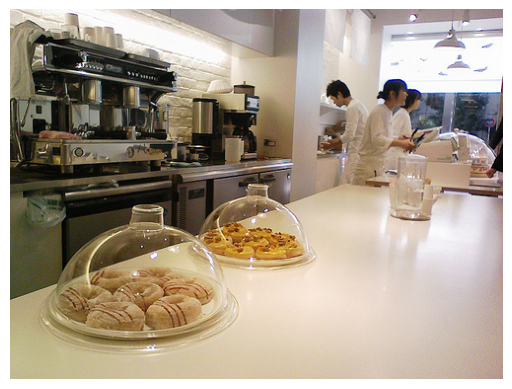

In [ ]:
##checking if the function works
test = open_image(enc_test=enc_test)

VGG Model-01: a desk with a laptop computer and a monitor          
Best VGG Model: a living room with a television and a television          
Resnet Model: a couple of people standing on a bench next to a building       


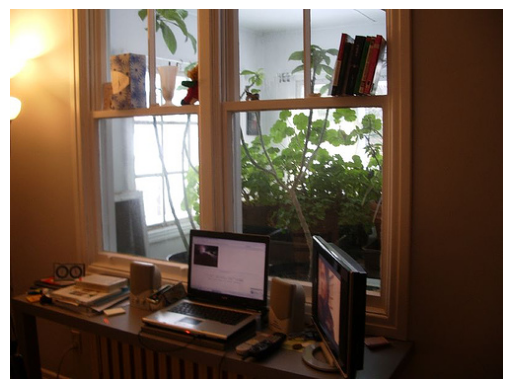

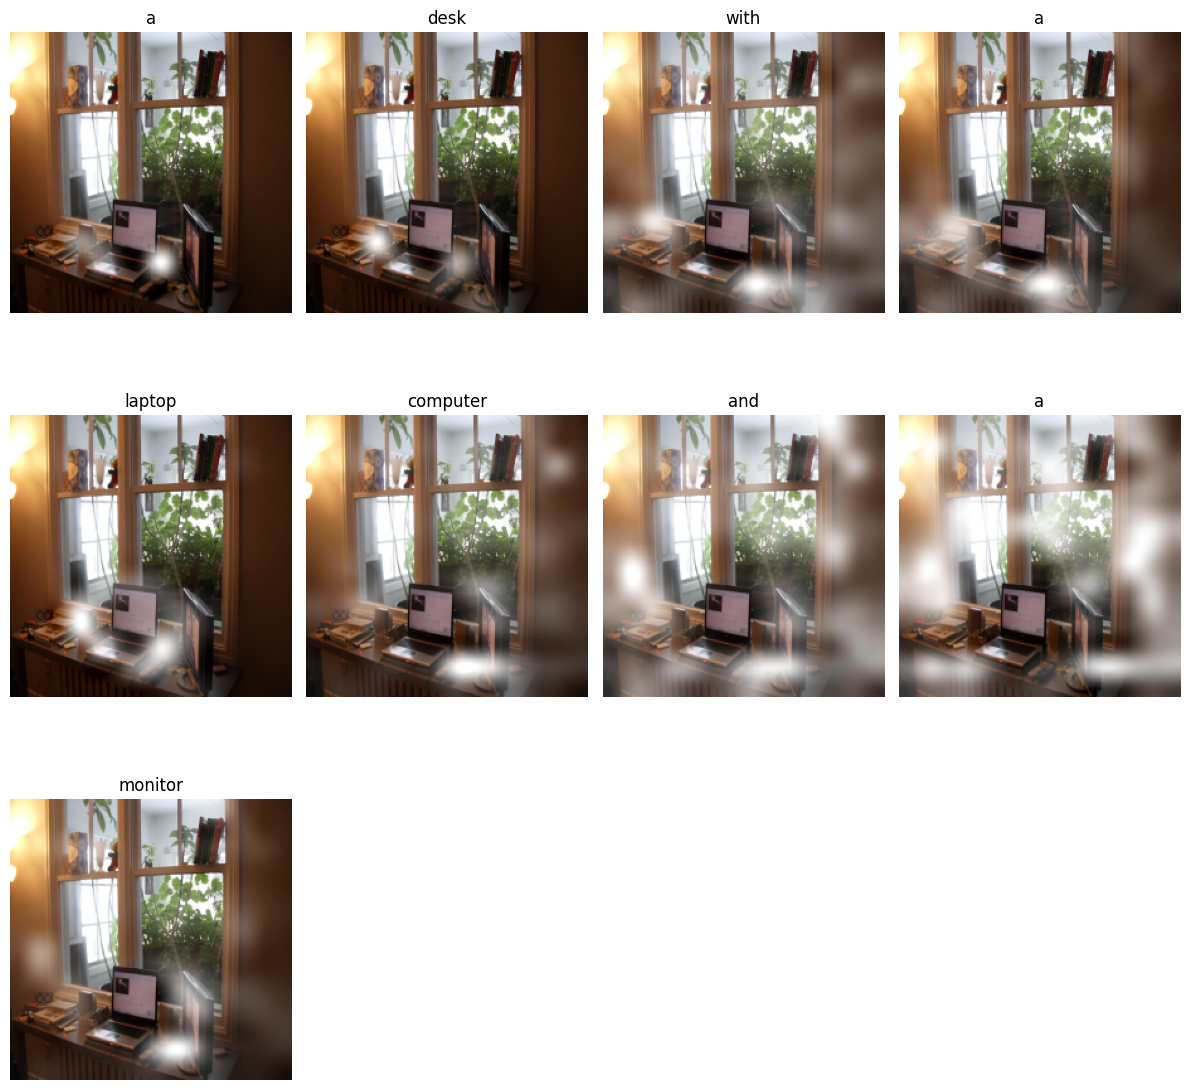

In [ ]:
test,img_path=open_image(enc_test=enc_test)

caption1,maps1 = get_caption(model_01,vgg19,test)
caption2,maps2 = get_caption(best_model,vgg19,test)
caption3,maps3= get_caption(model_resnet,resnet50,test)

print(f'VGG Model-01: {caption1}')
print(f'Best VGG Model: {caption2}')
print(f'Resnet Model: {caption3}')

visualize_attention(os.path.join(test_images,img_path),caption1,maps1,size=14)